# ECG anomaly prediction

1. Required dependency import

In [23]:
import wfdb as wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.utils.data import evaluate_print

2. Loading the MIT-BIH Arrythmmia dataset

In [24]:
record_path = "C:\\Anul III\\TIA\\datasets\\mit-bih-arrhythmia-database-1.0.0\\mit-bih-arrhythmia-database-1.0.0\\100"
record = wfdb.rdrecord(record_path)
signal = record.p_signal

3.1. Visualizing the crude data

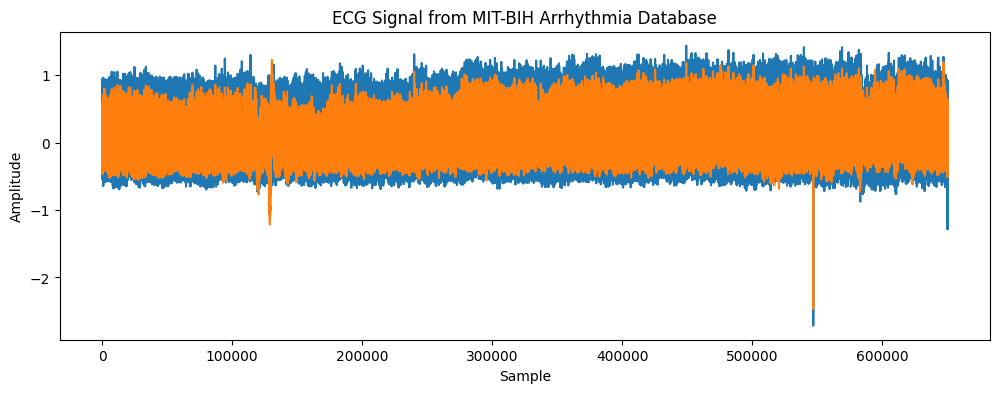

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title('ECG Signal from MIT-BIH Arrhythmia Database')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


3.2. Visualizing a few seconds of an ECG.

Text(0, 0.5, 'Amplitude (mV)')

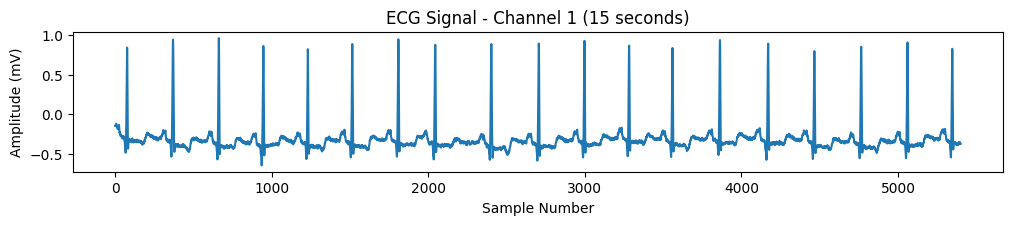

In [26]:
sampling_frequency = 360  # Hz
duration = 15  # 
num_samples = sampling_frequency * duration

signal_scaled = signal[:num_samples, :]

plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(signal_scaled[:, 0])
plt.title('ECG Signal - Channel 1 (' + str(duration)  + ' seconds)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')

4. Data preprocessing

In [27]:
scaler = StandardScaler()

signal_scaled = scaler.fit_transform(signal)

5.1. Isolation Forest

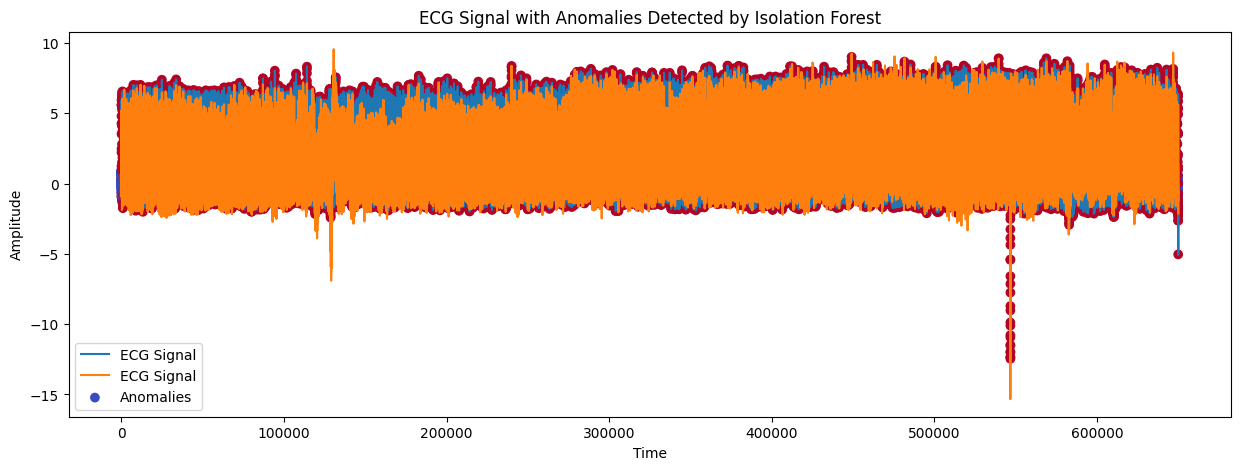

In [28]:
# Fit the Isolation Forest model from pyod
iso_forest = IForest(contamination=0.1, random_state=42)
iso_forest.fit(signal_scaled)

# Predict anomalies
anomalies_iforest = iso_forest.predict(signal_scaled)

# Convert predictions to boolean (1 for anomaly, 0 for normal)
anomalies_iforest = np.where(anomalies_iforest == 1, 1, 0)

signal_subset = signal_scaled[:num_samples]

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(signal_scaled, label='ECG Signal')
plt.scatter(np.arange(len(signal_scaled)), signal_scaled[:, 0], c=anomalies_iforest, cmap='coolwarm', label='Anomalies')
plt.title('ECG Signal with Anomalies Detected by Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



4.2. CBLOF - Cluster-Based Local Outlier Factor

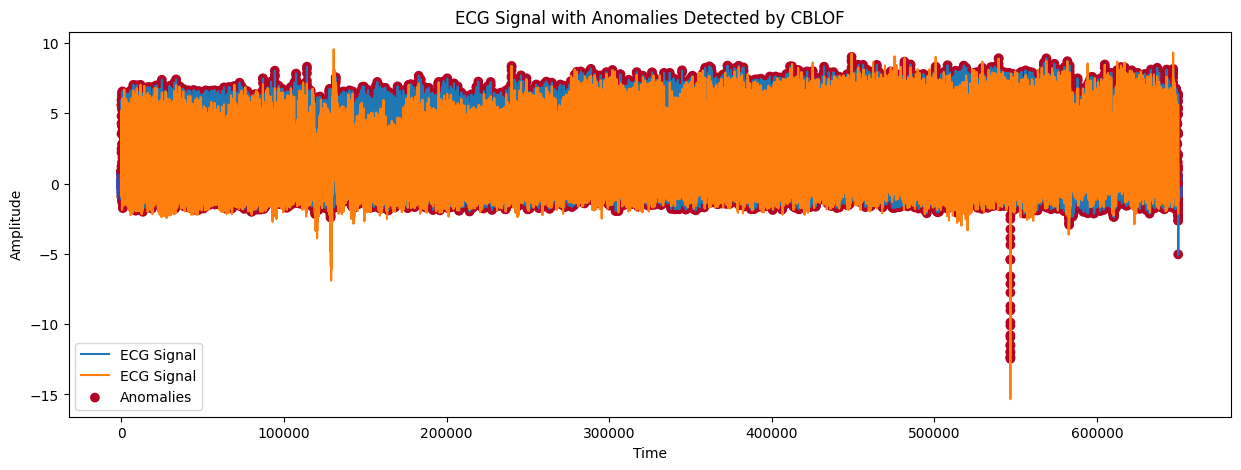

In [29]:
cblof = CBLOF(contamination=0.1, random_state=42)
cblof.fit(signal_scaled)

anomalies_cblof = cblof.predict(signal_scaled)

anomalies_cblof = np.where(anomalies_cblof == 1, 1, 0)

num_channels = signal_scaled.shape[1]
plt.figure(figsize=(15, 5))
plt.plot(signal_scaled, label='ECG Signal')
plt.scatter(np.arange(len(signal_scaled)), signal_scaled[:, 0], c=anomalies_cblof, cmap='coolwarm', label='Anomalies')
plt.title('ECG Signal with Anomalies Detected by CBLOF')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

4.3. HBOS

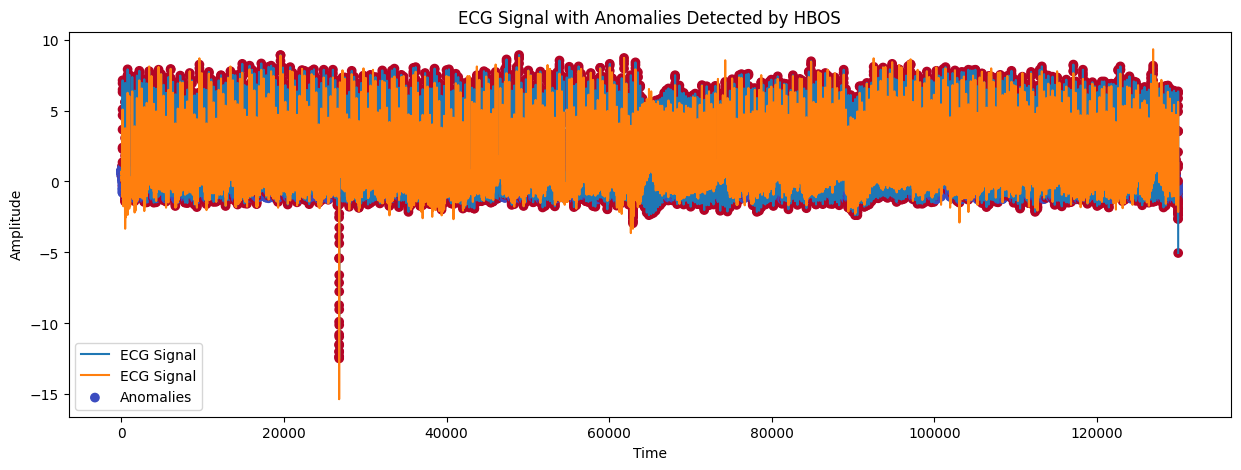

In [30]:
# Split the data into training and test sets
n_train = int(0.8 * len(signal_scaled))
X_train, X_test = signal_scaled[:n_train], signal_scaled[n_train:]

# Initialize the HBOS detector
hbos = HBOS()

# Fit the model
hbos.fit(X_train)

# Get the outlier scores
y_train_scores = hbos.decision_function(X_train)  # outlier scores for training data
y_test_scores = hbos.decision_function(X_test)    # outlier scores for test data


y_train_pred = hbos.labels_  
y_test_pred = hbos.predict(X_test)  

plt.figure(figsize=(15, 5))
plt.plot(signal_scaled[n_train:], label='ECG Signal')
plt.scatter(np.arange(len(X_test)), X_test[:, 0], c=y_test_pred, cmap='coolwarm', label='Anomalies')
plt.title('ECG Signal with Anomalies Detected by HBOS')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()